#Financial Time Series Analisys for Raizen Company


---


This is a non-guided personal project

by: Victor Hugo Lopes Benedito


For this project, the initial idea was to create a deep learning model to predict the Raizen stock prices using the prices of sugar and ethanol. I selected the prices of ethanol and sugar from the USA and China, respectively, because they are the two main products of Raizen and they have a significant impact on the company's sales. This project have 4 methods applied.

##1# Case ARIMA/SARIMA Method
##2# Case FBProphet
##3# Case LSTM
##4# Case Multiple Temporal Series with RNN



---



Since I plan to use the data for future projects, I will proceed with data cleaning and maintenance. Here is the link to the data:

Raizen Stock Prices ~> https://www.google.com/finance/quote/RAIZ4:BVMF?sa=X&ved=2ahUKEwjP-5uIlfn_AhWsupUCHR7RA1UQ3ecFegQINhAf

Sugar China ~> https://www.investing.com/commodities/zce-white-sugar-futures-historical-data

Ethanol USA ~> https://www.investing.com/commodities/ethanol-futures

Sugar and Ethanol Brasil ~> https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx





---

##Main Objective
Try predict stock market from the Raizen Company and test the different methods of solving this problem



---



##Imports

In [ ]:
!pip install forex-python
!pip install pmdarima
!pip install --upgrade plotly
!pip install pystan
!pip install prophet

In [ ]:
import pandas as pd
from forex_python.converter import CurrencyRates
from datetime import datetime, timedelta
from numpy import NaN
from dateutil import parser
from google.colab import files
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools as ts
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
directory = "/content/DATA_READY"
if not os.path.exists(directory):
    os.makedirs(directory)

#1. Data Preparation and Cleaning

In [ ]:
df_main=pd.read_excel("RAIZEN_Google_Finances.xlsx")
df_main['Date'] = df_main['Date'].dt.strftime("%m/%d/%y")
df_main = df_main.rename(columns={'Close': 'Price_Real_Raizen'})
df_main.to_csv('/content/DATA_READY/STOCK_RAIZEN_PRICE.csv', index=False)
df_main

,Date,Price_Real_Raizen
0,08/05/21,7.24
1,08/06/21,7.10
2,08/09/21,7.07
3,08/10/21,7.10
4,08/11/21,6.87
...,...,...
469,06/23/23,4.35
470,06/26/23,4.42
471,06/27/23,4.44
472,06/28/23,4.39


##1.1 Let's take the market price of each main product (Sugar and Ethanol) and format the datatype to DD/MM/YY (we will do this only in non-brazilian archives) and save this in a new csv (so we don't need to rerun this code)

In [ ]:
df=pd.read_csv("ETHANOL_USA.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,08/06/2018,1.434,1.441,1.490,1.425,0.15K,0.28%
1,08/07/2018,1.421,1.432,1.435,1.416,0.13K,-0.91%
2,08/08/2018,1.389,1.412,1.421,1.383,0.22K,-2.25%
3,08/09/2018,1.370,1.381,1.385,1.362,0.27K,-1.37%
4,08/10/2018,1.349,1.365,1.366,1.344,0.27K,-1.53%
...,...,...,...,...,...,...,...
1231,06/23/2023,2.161,2.161,2.161,2.161,NaN,0.00%
1232,06/26/2023,2.161,2.161,2.161,2.161,NaN,0.00%
1233,06/27/2023,2.161,2.161,2.161,2.161,NaN,0.00%
1234,06/28/2023,2.161,2.161,2.161,2.161,NaN,0.00%


In [ ]:
subset = df[['Date', 'Price']].copy()
subset.dtypes

Date      object
Price    float64
dtype: object

In [ ]:
subset['Date'] = subset['Date'].apply(lambda x: parser.parse(x) if isinstance(x, str) else x)

In [ ]:
subset['Date'] = pd.to_datetime(subset['Date'], format='%m/%d/%Y').dt.strftime('%m/%d/%y')
subset = subset[pd.to_datetime(subset['Date']) >= pd.to_datetime('08/05/21')].copy().reset_index(drop=True)
subset=subset.rename(columns={'Price': 'Price_Dolar_Ethanol_USA'})
subset

,Date,Price_Dolar_Ethanol_USA
0,08/05/21,2.220
1,08/06/21,2.220
2,08/09/21,2.220
3,08/10/21,2.220
4,08/11/21,2.220
...,...,...
474,06/23/23,2.161
475,06/26/23,2.161
476,06/27/23,2.161
477,06/28/23,2.161


In [ ]:
subset.to_csv('/content/DATA_READY/ETHANOL_EUA_PRICE.csv', index=False)

In [ ]:
df=pd.read_csv("SUGAR_CHINA.csv")
subset = df[['Date', 'Price']].copy()
subset['Date'] = subset['Date'].apply(lambda x: parser.parse(x) if isinstance(x, str) else x)
subset['Date'] = pd.to_datetime(subset['Date'], format='%m/%d/%Y').dt.strftime('%m/%d/%y')
subset=subset.rename(columns={'Price': 'Price_Yuan_Sugar_CHINA'})
subset = subset[pd.to_datetime(subset['Date']) >= pd.to_datetime('08/05/21')].copy().reset_index(drop=True)
subset=subset.iloc[::-1].reset_index(drop=True)
subset['Price_Yuan_Sugar_CHINA']=subset['Price_Yuan_Sugar_CHINA'].str.replace(',',"",regex=True).astype(float)
subset

,Date,Price_Yuan_Sugar_CHINA
0,08/05/21,5561.0
1,08/06/21,5645.0
2,08/09/21,5684.0
3,08/10/21,5632.0
4,08/11/21,5673.0
...,...,...
453,06/20/23,6992.0
454,06/21/23,6982.0
455,06/26/23,6880.0
456,06/27/23,6814.0


In [ ]:
subset.to_csv('/content/DATA_READY/SUGAR_CHINA_PRICE.csv', index=False)

We will deal with the exchange rate later

In [ ]:
df=pd.read_excel("SUGAR_BRASIL.xls")
df=df.rename(columns={"Data":"Date",
    'À vista R$': 'Price_Real_Sugar_Brasil'})
subset = df[['Date', 'Price_Real_Sugar_Brasil']].copy()
subset['Date'] = pd.to_datetime(subset['Date'], format='%d/%m/%Y').dt.strftime('%m/%d/%y')
subset = subset[pd.to_datetime(subset['Date']) >= pd.to_datetime('08/05/21')].copy().reset_index(drop=True)
subset

,Date,Price_Real_Sugar_Brasil
0,08/05/21,120.49
1,08/06/21,120.57
2,08/09/21,119.58
3,08/10/21,121.72
4,08/11/21,122.59
...,...,...
469,06/23/23,143.37
470,06/26/23,143.45
471,06/27/23,143.06
472,06/28/23,140.95


In [ ]:
subset.to_csv('/content/DATA_READY/SUGAR_BRASIL_PRICE.csv', index=False)

In [ ]:
df=pd.read_excel("ETHANOL_BRASIL.xls")
df=df.rename(columns={"Data":"Date",
    'À vista R$': 'Price_Real_Ethanol_Brasil'})
subset = df[['Date', 'Price_Real_Ethanol_Brasil']].copy()
subset['Date'] = pd.to_datetime(subset['Date'], format='%d/%m/%Y').dt.strftime('%m/%d/%y')
subset = subset[pd.to_datetime(subset['Date']) >= pd.to_datetime('08/05/21')].copy().reset_index(drop=True)
subset['Price_Real_Ethanol_Brasil']=subset['Price_Real_Ethanol_Brasil'].str.replace('.',"",regex=True)
subset['Price_Real_Ethanol_Brasil']=subset['Price_Real_Ethanol_Brasil'].str.replace(',',".",regex=True).astype(float)
subset

,Date,Price_Real_Ethanol_Brasil
0,08/05/21,3117.0
1,08/06/21,3164.0
2,08/09/21,3189.5
3,08/10/21,3195.5
4,08/11/21,3214.0
...,...,...
469,06/23/23,2606.0
470,06/26/23,2617.0
471,06/27/23,2615.5
472,06/28/23,2620.5


In [ ]:
subset.to_csv('/content/DATA_READY/ETHANOL_BRASIL_PRICE.csv', index=False)

##Joining all the data

All the data now is in format MM/DD/YY so lets append all together and deal with missing values

In [ ]:
diretorio = '/content/DATA_READY'
lista_dataframes = []
for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.csv'):
        caminho_arquivo = os.path.join(diretorio, arquivo)
        df = pd.read_csv(caminho_arquivo)
        lista_dataframes.append(df)

df_final = pd.concat(lista_dataframes, ignore_index=True)
df_grouped = df_final.groupby('Date').mean().reset_index()
df_grouped['Date'] = pd.to_datetime(df_grouped['Date'], format='%m/%d/%y')
df_grouped=df_grouped.sort_values('Date').reset_index(drop=True)
df_grouped

,Date,Price_Real_Ethanol_Brasil,Price_Yuan_Sugar_CHINA,Price_Real_Raizen,Price_Real_Sugar_Brasil,Price_Dolar_Ethanol_USA,Price_Real_Ethanol_USA,Price_Real_Sugar_CHINA
0,2021-08-05,3117.0,5561.0,7.24,120.49,2.220,NaN,NaN
1,2021-08-06,3164.0,5645.0,7.10,120.57,2.220,NaN,NaN
2,2021-08-09,3189.5,5684.0,7.07,119.58,2.220,NaN,NaN
3,2021-08-10,3195.5,5632.0,7.10,121.72,2.220,NaN,NaN
4,2021-08-11,3214.0,5673.0,6.87,122.59,2.220,NaN,NaN
...,...,...,...,...,...,...,...,...
491,2023-06-23,2606.0,NaN,4.35,143.37,2.161,NaN,NaN
492,2023-06-26,2617.0,6880.0,4.42,143.45,2.161,NaN,NaN
493,2023-06-27,2615.5,6814.0,4.44,143.06,2.161,NaN,NaN
494,2023-06-28,2620.5,6749.0,4.39,140.95,2.161,NaN,NaN


In [ ]:
df_grouped.set_index('Date', inplace=True)

#2. Preprocessing

In [ ]:
df_grouped["Price_Real_Ethanol_USA"]=df_grouped["Price_Dolar_Ethanol_USA"]/df_grouped.index.map(lambda x: convert_dollar_to_real(x))

In [ ]:
df_grouped["Price_Real_Sugar_CHINA"]=df_grouped["Price_Yuan_Sugar_CHINA"]/df_grouped.index.map(lambda x: convert_yuan_to_real(x))

In [ ]:
df_grouped = df_grouped.drop(df_grouped[(df_grouped["Price_Real_Sugar_CHINA"] <= 1000) | (df_grouped["Price_Real_Sugar_CHINA"] > 10000)].index)
df_grouped = df_grouped.drop(df_grouped[(df_grouped["Price_Real_Ethanol_USA"] <= 5) | (df_grouped["Price_Real_Ethanol_USA"] > 35)].index)

In [ ]:
df_grouped.describe()

,Price_Real_Ethanol_Brasil,Price_Yuan_Sugar_CHINA,Price_Real_Raizen,Price_Real_Sugar_Brasil,Price_Dolar_Ethanol_USA,Price_Real_Ethanol_USA,Price_Real_Sugar_CHINA
count,469.000000,453.000000,469.000000,469.000000,474.000000,473.000000,453.000000
mean,3070.680171,5890.571744,5.007804,137.975480,2.168213,11.289404,4568.870765
std,369.036934,415.611041,1.453874,9.326755,0.020171,0.561492,317.315644
min,2297.000000,5452.000000,2.260000,119.580000,2.137000,9.921546,3836.840212
25%,2801.000000,5620.000000,3.710000,130.030000,2.160000,10.926363,4343.184772
50%,2984.000000,5767.000000,4.850000,136.340000,2.161000,11.256385,4541.399468
75%,3367.000000,5935.000000,6.330000,145.490000,2.161000,11.639204,4800.316013
max,3994.500000,7170.000000,7.370000,157.430000,2.220000,12.582367,5318.605146


In [ ]:
df_grouped=df_grouped.interpolate()

In [ ]:
df_final = df_grouped[["Price_Real_Sugar_Brasil", "Price_Real_Ethanol_Brasil", "Price_Real_Ethanol_USA", "Price_Real_Sugar_CHINA","Price_Real_Raizen"]].copy()

In [ ]:
df_final.to_csv('/content/DATA_READY/ALL_DATA_JOINED.csv', index=True)

#3. Defined Functions

In [ ]:
def converter_data(data_string):
    try:
      data_objeto = datetime.strptime(data_string, "%Y-%m-%d %H:%M:%S.%f")
    except:
      data_objeto = (data_string)
    return data_objeto.strftime("%m/%d/%y")

In [ ]:
from numpy import NaN
def convert_dollar_to_real(date):

    c = CurrencyRates()
    try:
      rate = c.get_rate('BRL', 'USD', date)
    except:
      rate = NaN
    return rate

def convert_yuan_to_real(date):

    c = CurrencyRates()
    try:
      rate = c.get_rate('BRL', 'CNY', date)
    except:
      rate = NaN
    return rate

In [ ]:
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

def cross_validate(series,horizon,start,step_size,order,seasonal_order,trend):

    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        print(i)
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start
                                order=order,
                                seasonal_order=seasonal_order,
                                trend=trend).fit()
        fcst.append(model.forecast(steps = step_size)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [ ]:
def fit_LSTM(train_X, train_y, cell_units, epochs):


    model = Sequential()
    print(train_X.shape[1])
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

In [ ]:
def create_samples(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

#1# Case ARIMA/SARIMA Method

In this part, several issues have arisen. For instance, there were numerous missing data points that were filled using interpolation, which can introduce some degree of unreliability in the data by smoothing out fluctuations and reducing residual variability. Additionally, an attempt was made to work with weekly frequency, but the dataset size was not large enough to allow for efficient analysis.

These challenges highlight the importance of data quality and quantity in conducting robust financial analysis. When missing data are filled through interpolation, it is crucial to recognize that the resulting values may not accurately represent the true underlying patterns and dynamics of the stock prices. This could potentially impact the reliability of any conclusions drawn from the analysis.

Furthermore, the limitation of dataset size can hinder the effectiveness of certain analysis techniques. In the case of using weekly frequency, a larger dataset is generally preferred to capture sufficient information and improve the accuracy of forecasts or models. With a smaller dataset, it becomes more challenging to extract meaningful insights or establish reliable relationships.

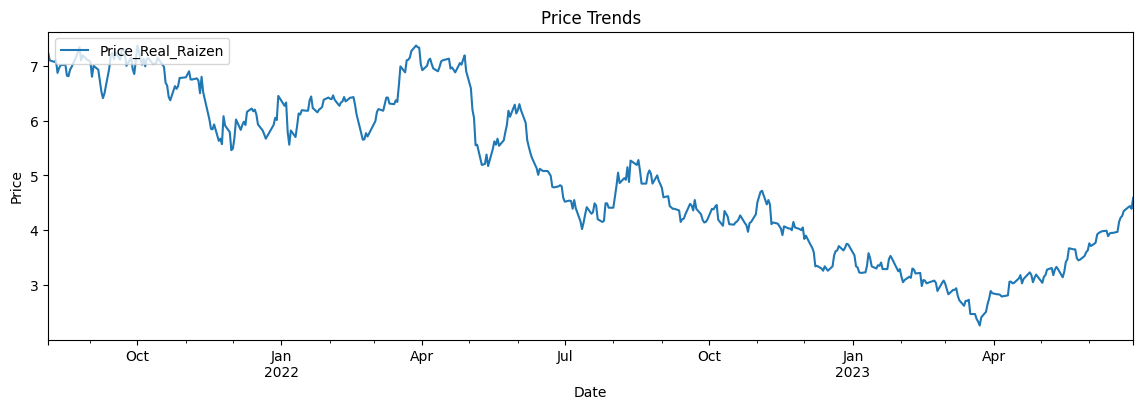

In [ ]:
df_raizen = pd.read_csv("/content/DATA_READY/STOCK_RAIZEN_PRICE.csv")
df_raizen["Date"]=pd.to_datetime(df_raizen['Date'])
df_raizen.set_index('Date', inplace=True)
df_raizen=df_raizen.asfreq('D')
df_raizen=df_raizen.interpolate()
df_raizen.plot(kind='line',figsize=(14,4))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Trends')
plt.legend(loc='upper left')
plt.show()

We can see some 2 different Trends and this may cause trouble

In [ ]:
chunks = np.split(df_raizen.Price_Real_Raizen[1:], indices_or_sections=11)
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,7.034444,0.036408
1,6.400556,0.255519
2,6.133333,0.057757
3,6.560476,0.259247
4,6.020794,0.476885
5,4.657619,0.122306
6,4.444841,0.081104
7,3.955714,0.160871
8,3.316825,0.042623
9,2.836825,0.058283


We want to stabilize our mean and variance

In [ ]:
def dftest(timeseries,n):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    plt.rcParams['figure.figsize'] = [14, 4]
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=n).mean()
    rolstd = timeseries.rolling(window=n).std()
    print(dfoutput)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -1.570831
p-value                   0.498227
Lags Used                 2.000000
Observations Used       691.000000
Critical Value (1%)      -3.439849
Critical Value (5%)      -2.865732
Critical Value (10%)     -2.569002
dtype: float64


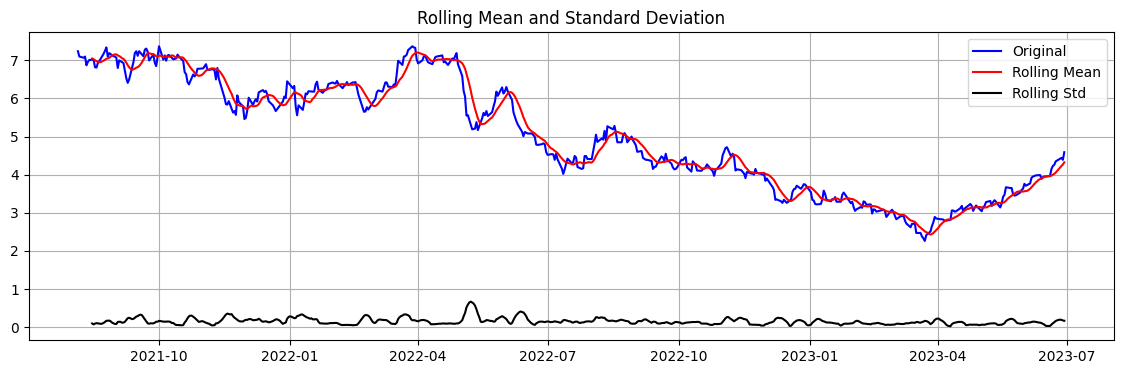

In [ ]:
dftest(df_raizen.Price_Real_Raizen,len(chunks))

In [ ]:
df_raizen['Price_Real_Raizen_log'] = np.log1p(df_raizen['Price_Real_Raizen'])
df_raizen['Price_Real_Raizen_log_diff_s']=df_raizen['Price_Real_Raizen_log']-df_raizen['Price_Real_Raizen_log'].shift(3)

After a long period looking for transformations, suavization curves and a lot of "seasonal patterns" this

Test Statistic         -6.112149e+00
p-value                 9.277439e-08
Lags Used               2.000000e+01
Observations Used       6.700000e+02
Critical Value (1%)    -3.440148e+00
Critical Value (5%)    -2.865863e+00
Critical Value (10%)   -2.569072e+00
dtype: float64


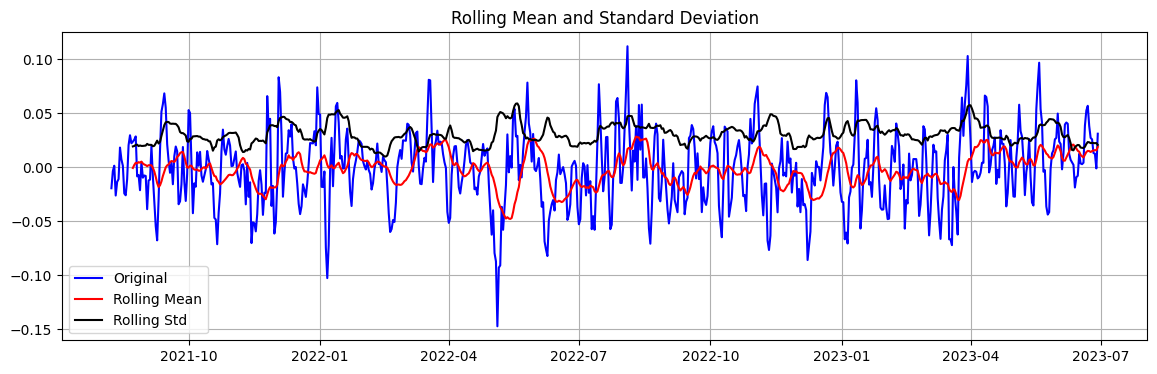

In [ ]:
dftest(df_raizen.Price_Real_Raizen_log_diff_s.dropna(),16)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


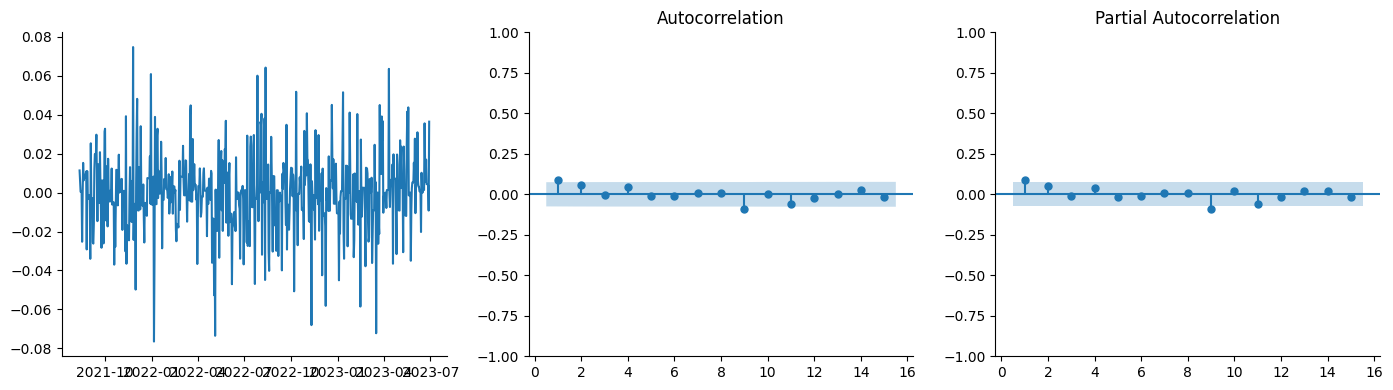

In [ ]:
plots(df_raizen.Price_Real_Raizen_log_diff[7:], lags=15)

In [ ]:
stepwise_model = pm.auto_arima(df_raizen.Price_Real_Raizen_log, start_p=1, start_q=1,d=7, m=3, seasonal=True, trace=True,trend="c",
                           error_action='ignore',
                           stepwise=True)

When looking this d value looks like a overdiff but later it actually fits well the data

In [ ]:
sar = sm.tsa.statespace.SARIMAX(df_raizen.Price_Real_Raizen_log,
                                order=(1,7,0),
                                seasonal_order=(1,0,0,3),seasonal=True,
                                trend="c").fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:             Price_Real_Raizen_log   No. Observations:                  694
Model:             SARIMAX(1, 7, 0)x(1, 0, 0, 3)   Log Likelihood                   3.695
Date:                           Thu, 06 Jul 2023   AIC                              0.609
Time:                                   04:13:40   BIC                             18.738
Sample:                               08-05-2021   HQIC                             7.623
                                    - 06-29-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.054e-05      0.009      0.006      0.996      -0.018       0.018
ar.L1         -0.9232      0.013    -68.837      0.000      -0.950      -0.897
ar.S.L3        0.4120      0.033     12.614      0.000       0.348       0.476
sigma2         0.0577      0.003     20.657      0.000       0.052       0.063
===================================================================================
Ljung-Box (L1) (Q):                 320.35   Jarque-Bera (JB):                16.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.02
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:

series = df_raizen.Price_Real_Raizen_log
horizon = 10
start = 670
step_size = 1
order = sar.specification.order
seasonal_order = sar.specification.seasonal_order

cv1 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order,trend="c")

670
671
672
673
674
675
676
677
678
679
680
681
682
683


In [ ]:
exp_f=np.expm1(cv1)

In [ ]:
exp_f

,fcst,actual
2023-06-16,5.482995,3.950000
2023-06-17,2.530892,3.956667
2023-06-18,5.476073,3.963333
2023-06-19,3.826437,3.970000
2023-06-20,3.606856,4.150000
2023-06-21,4.250451,4.230000
2023-06-22,3.703154,4.260000
2023-06-23,3.740320,4.350000
2023-06-24,5.085653,4.373333
2023-06-25,2.987430,4.396667


In [ ]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [ ]:
mape(exp_f)

0.16898054801916165

17 % of error is not that bad in this case because we could have lower values but the data wouldn't be fitted well in all cases

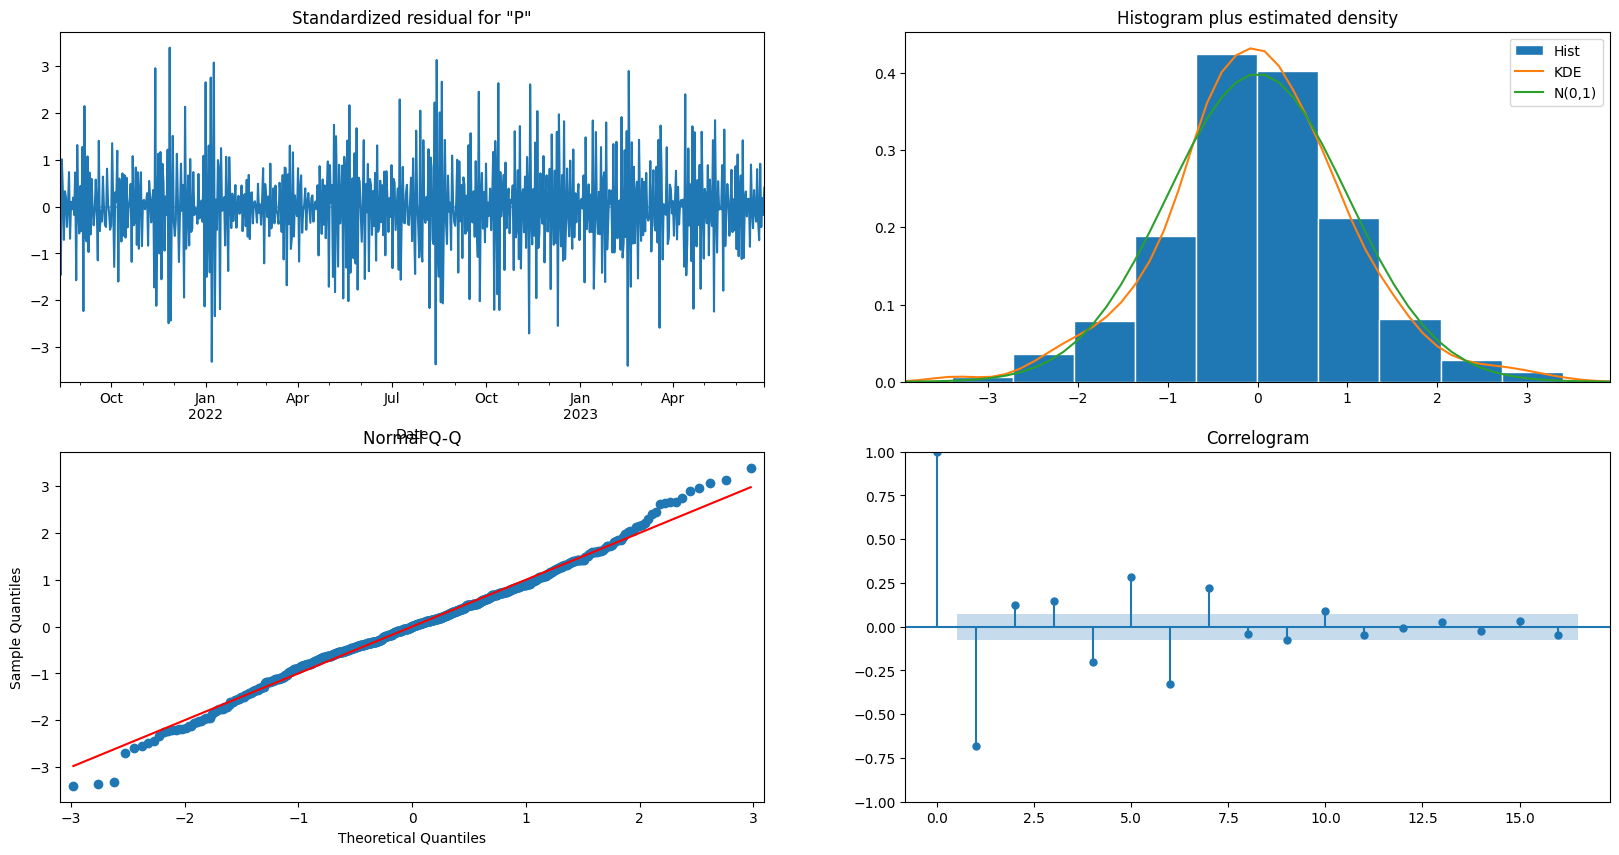

In [ ]:
sar.plot_diagnostics(lags=16,figsize = (20,10),);

<Axes: >

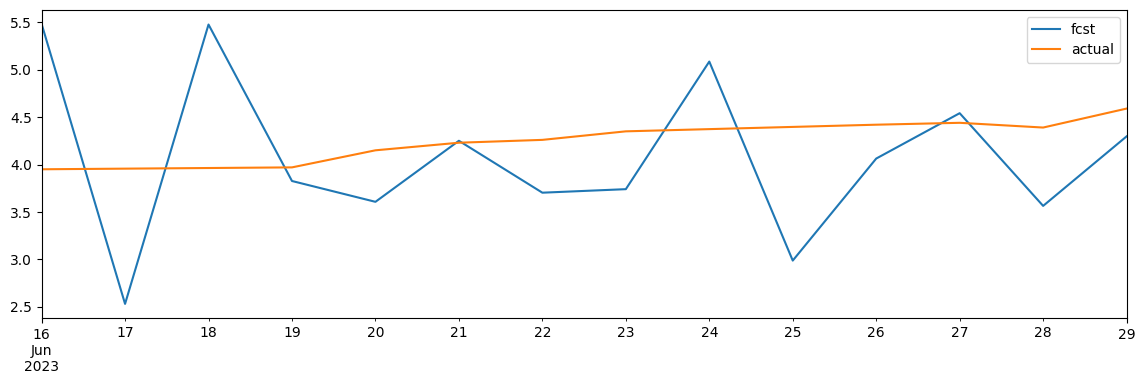

In [ ]:
exp_f.plot()

In [ ]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=16.706, p=0.000
Ljung-Box: val=503.603, p=0.000
Heteroskedasticity: val=1.100, p=0.471
Durbin-Watson: d=3.36


Tests results

*   The results presents no normal distribution (Normality value high)
*   Autocorrelation is present in the data (LJung)
*   No Heteroskedasticity
*  Negative Autocorrelation in data (2 < Durbin-Watson < 4)


#2# Case FBProphet


FBProphet have some limitations but is really easy to apply so we should give it a try.

In [ ]:
prophet_data=pd.read_csv("/content/DATA_READY/STOCK_RAIZEN_PRICE.csv")
prophet_data=prophet_data.rename(columns={'Date': 'ds',"Price_Real_Raizen":"y"})

In [ ]:
prophet_data

,ds,y
0,08/05/21,7.24
1,08/06/21,7.10
2,08/09/21,7.07
3,08/10/21,7.10
4,08/11/21,6.87
...,...,...
469,06/23/23,4.35
470,06/26/23,4.42
471,06/27/23,4.44
472,06/28/23,4.39


In [ ]:
m = Prophet()
m.fit(prophet_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9exqd8lu/x38bmzvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9exqd8lu/squtfhk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47637', 'data', 'file=/tmp/tmp9exqd8lu/x38bmzvq.json', 'init=/tmp/tmp9exqd8lu/squtfhk4.json', 'output', 'file=/tmp/tmp9exqd8lu/prophet_model2oabq_c1/prophet_model-20230706022809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:28:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=70,include_history=True)

In [ ]:
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
539,2023-09-03,3.994091,3.428565,4.549657
540,2023-09-04,4.013893,3.479217,4.533381
541,2023-09-05,4.011789,3.452195,4.556434
542,2023-09-06,4.025236,3.481615,4.618024
543,2023-09-07,4.038600,3.480474,4.563160


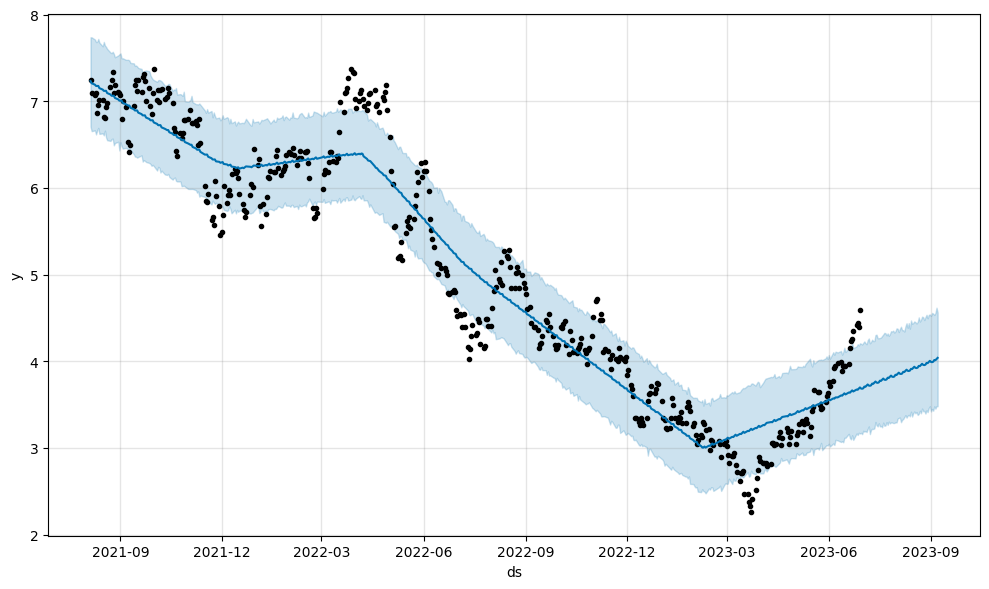

In [ ]:
m.plot(forecast);

The FBProphet tried to catch the trend but he didn't fit really well

# 3# Case LSTM

The LSTM model, is a promising approach in theory as it has the potential to yield favorable results. Particularly in cases where the dataset is limited in terms of quantity. The LSTM architecture is known for its ability to capture long-term relationships in sequences, enabling the modeling of complex temporal dependencies. Therefore, even when the available dataset is relatively small, LSTM can be effective in extracting significant patterns and making accurate predictions.

In [ ]:
df_raizen = pd.read_csv("/content/DATA_READY/STOCK_RAIZEN_PRICE.csv")
df_raizen["Date"]=pd.to_datetime(df_raizen['Date'])
df_raizen.set_index('Date', inplace=True)
df_raizen=df_raizen.asfreq('D')
df_raizen=df_raizen.interpolate()

In [ ]:

# Reshape the series as a 2D array with one column
series_array = df_raizen.values.reshape(-1, 1)
# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(series_array)

# Split the scaled data into train and test sets
train_size = int(len(scaled_series) * 0.8)
train_data = scaled_series[:train_size]
test_data = scaled_series[train_size:]

# Split the train and test sets into train_X, train_y, test_X, test_y
train_X = train_data[:-1]  # input sequence samples for training
train_y = train_data[1:]  # next step in sequence targets for training
test_X = test_data[:-1]  # input sequence samples for testing
test_y = test_data[1:]  # next step in sequence targets for testing


model = fit_LSTM(train_X, train_y, cell_units=70, epochs=100)

1


5/5 [==============================] - 0s 2ms/step


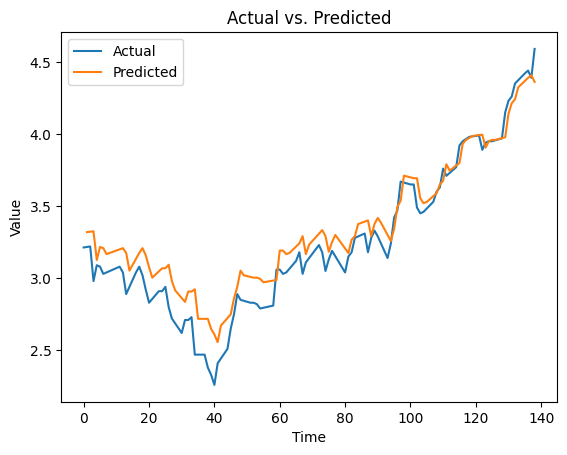

In [ ]:
test_predictions = model.predict(test_X)

# Inverse scale the predicted values
test_predictions = scaler.inverse_transform(test_predictions)
train_data=scaler.inverse_transform(train_data)
test_data=scaler.inverse_transform(test_data)
# Plot the actual and predicted values
plt.plot(range(len(test_data)), test_data, label='Actual')
plt.plot(range(1, len(test_data)), test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

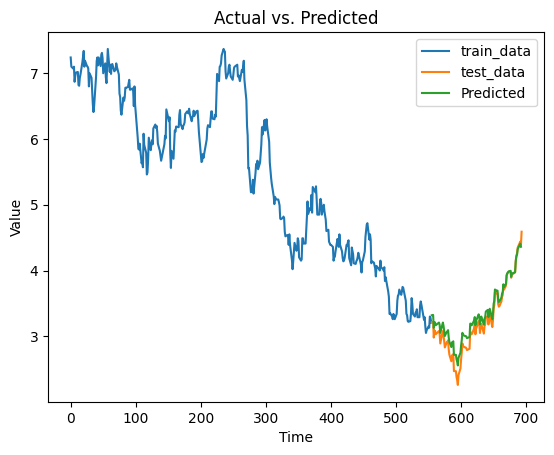

In [ ]:

# Plot the actual and predicted values
plt.plot(range(len(train_data)), train_data, label='train_data')
plt.plot(range(len(train_data),len(train_data)+len(test_data)), test_data, label='test_data')
plt.plot(range(len(train_data),len(train_data)+len(test_predictions)), test_predictions, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

LSTM was an absolutely good choice, the data fitted really well to the test data.

# 4# Case Multiple Temporal Series with RNN

In this particular case, when dealing with multiple time series, careful consideration was given to the choice of neural network model. Initially, LSTM  was chosen due to its ability to capture long-term relationships in sequences. However, even after adjusting parameters such as layers and training epochs, LSTM was unable to handle all the series satisfactorily.

Confronted with this limitation, an alternative approach using a regular RNN  was explored. The RNN, in turn, demonstrated greater effectiveness in handling this complex scenario of multiple time series. This choice can be attributed to the intrinsic characteristics of RNN, which allow for sequential processing of data without the need to maintain long-term information.

In [ ]:
df = pd.read_csv("/content/DATA_READY/ALL_DATA_JOINED.csv")
df["Date"]=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df=df.asfreq('D')
df=df.interpolate()


In [ ]:
df["Price_Real_Ethanol_Brasil"]=df["Price_Real_Ethanol_Brasil"]/1000
df["Price_Real_Sugar_CHINA"]=df["Price_Real_Sugar_CHINA"]/1000
df["Price_Real_Sugar_Brasil"]=df["Price_Real_Sugar_Brasil"]/100
df["Price_Real_Raizen"]=df["Price_Real_Raizen"]+2

<Axes: xlabel='Date'>

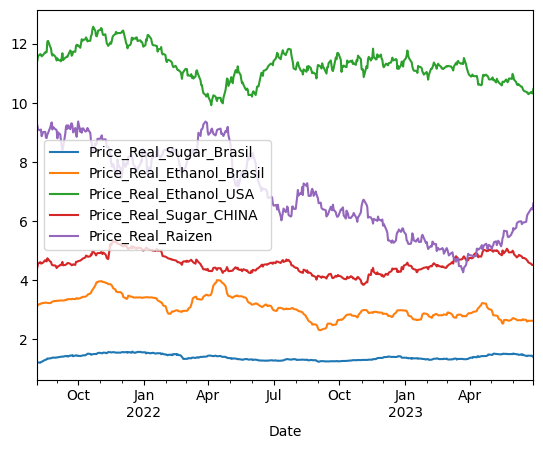

In [ ]:
df.plot()

In [ ]:

# Create a DataFrame for the time series data
num_series=5
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Define window size and create samples and targets
window_size = 10
train_X, train_y = create_samples(train_data, window_size)
test_X, test_y = create_samples(test_data, window_size)

model = Sequential()
model.add(SimpleRNN(64, input_shape=(window_size, num_series), return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(num_series))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=100, batch_size=64)

# Make predictions on the test data
test_predictions = model.predict(test_X)

# Inverse scale the actual and predicted values
test_y = scaler.inverse_transform(test_y)
test_predictions = scaler.inverse_transform(test_predictions)
train_y=scaler.inverse_transform(train_y)

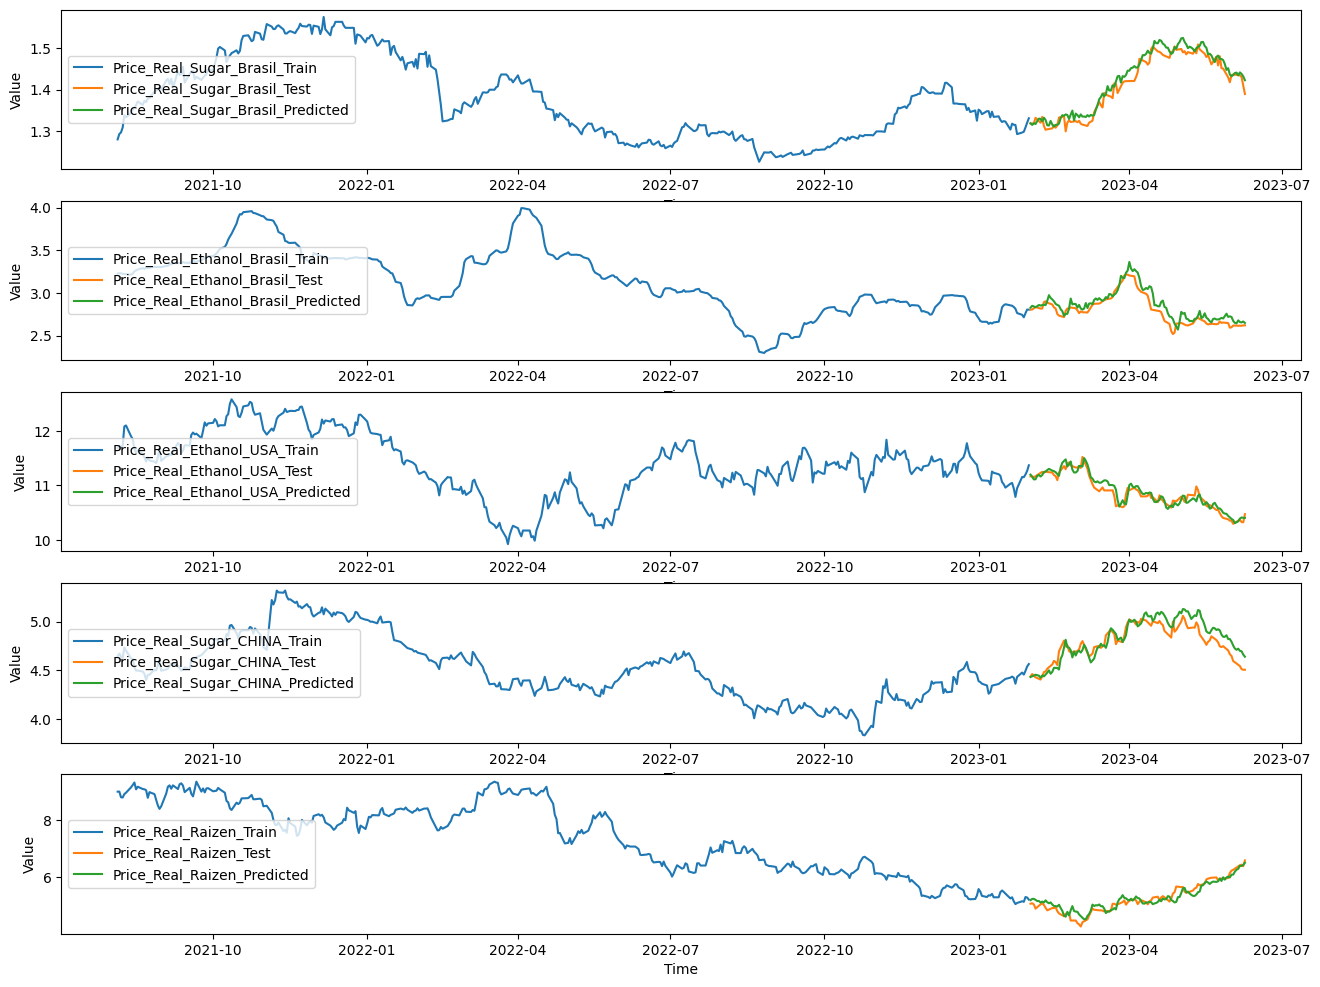

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(num_series):
    plt.subplot(num_series, 1, i+1)
    plt.plot(df.index[:(len(train_y[:, i]))], train_y[:, i], label=str(df.columns[i]) + "_Train")
    plt.plot(df.index[len(train_y[:, i]):(len(train_y[:, i])+len(test_y[:, i]))], test_y[:, i], label=str(df.columns[i]) + "_Test")
    plt.plot(df.index[len(train_y[:, i]):(len(train_y[:, i])+len(test_predictions[:, i]))], test_predictions[:, i], label=str(df.columns[i]) +'_Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc='center left')

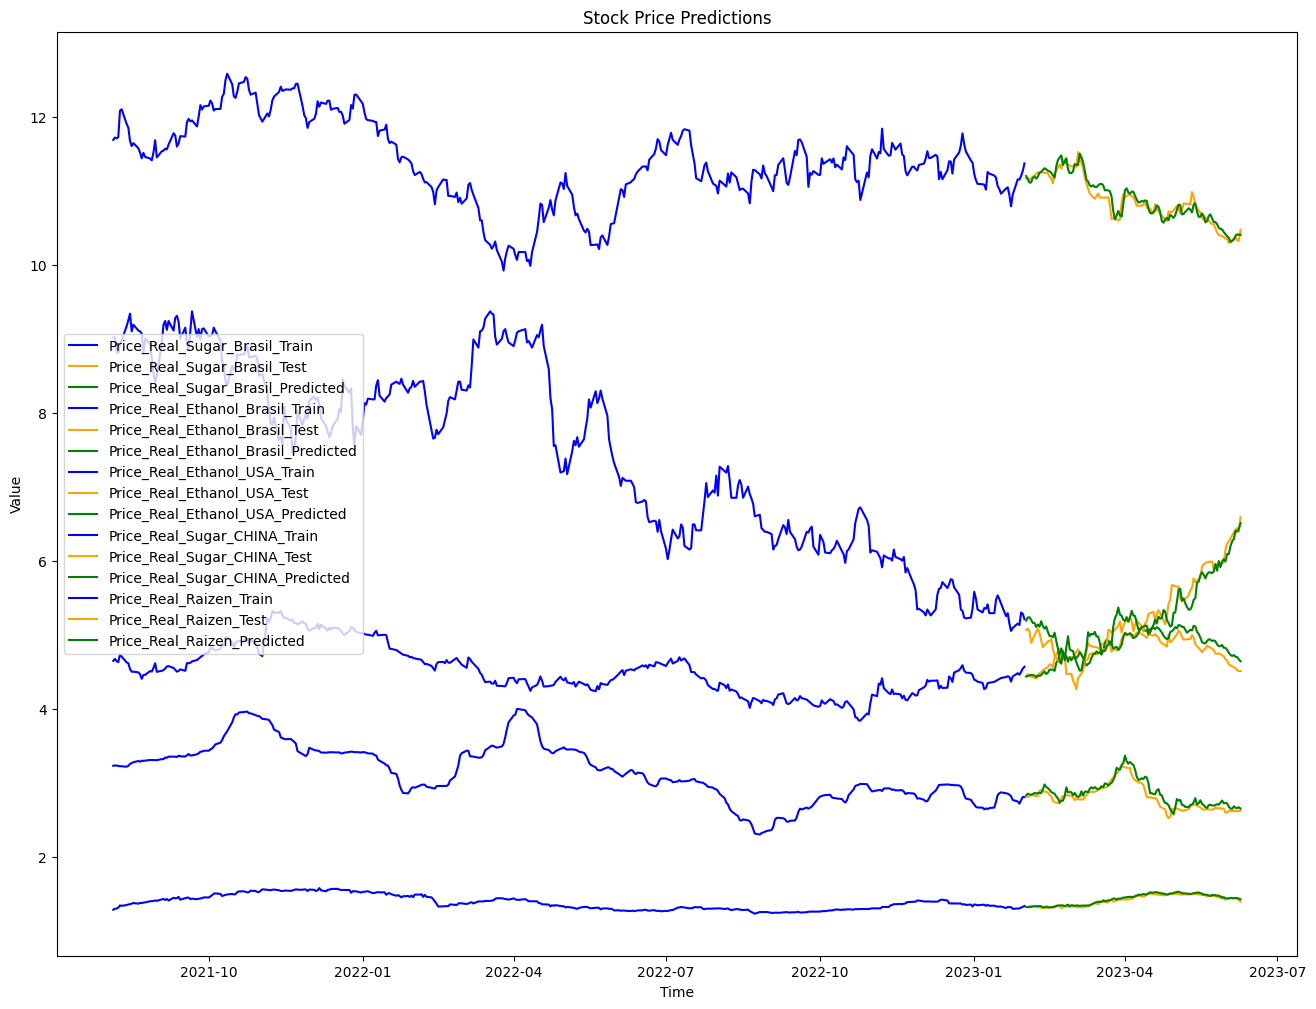

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(num_series):
    plt.plot(df.index[:(len(train_y[:, i]))], train_y[:, i], label=str(df.columns[i]) + "_Train",color='blue')
    plt.plot(df.index[len(train_y[:, i]):(len(train_y[:, i])+len(test_y[:, i]))], test_y[:, i], label=str(df.columns[i]) + "_Test",color='orange')
    plt.plot(df.index[len(train_y[:, i]):(len(train_y[:, i])+len(test_predictions[:, i]))], test_predictions[:, i], label=str(df.columns[i]) +'_Predicted',color='green')
    plt.xlabel('Time')
    plt.title("Stock Price Predictions")
    plt.ylabel('Value')
    plt.legend(loc='center left')



---


#Final Data Analisys about Raizen Stock Price
Upon analyzing the data, there appears to be a noticeable uptrend in the value of Raizen stocks, indicating a potential opportunity for a promising addition to a stock portfolio. The consistent upward movement suggests that Raizen has been performing well in the market and has the potential for further growth. Investors looking to diversify their portfolio and capitalize on this positive trend may consider adding Raizen stocks as part of their investment strategy.

By incorporating Raizen stocks into a well-diversified portfolio, investors may have the opportunity to benefit from potential future appreciation in the company's stock value. However, it is essential to remain vigilant and monitor the market dynamics to make informed decisions and adjust the portfolio as needed.



---



#Conclusion
The first 2 models (SARIMA and FBProphet) presented reasonable results but are far from perfect. A good approach to consider in the future could be using a GARCH model in conjunction with SARIMA. This combination can help improve the performance of financial time series analysis by effectively capturing both the autoregressive and conditional heteroskedasticity properties (which happens here) often observed in financial data. While ARIMA models handle the time-dependent patterns and trends in the data, GARCH models focus on capturing the volatility clustering and changing variances over time.

Both the LSTM and RNN models proved to be highly effective in fitting the data, and they offer the added advantage of being easier to configure compared to SARIMA/ARIMA models and FBProphet. Personally, I find deep learning models to be my preferred choice when fitting data. Their flexibility and ability to capture complex patterns and dependencies make them well-suited for a wide range of time series forecasting tasks. By leveraging deep learning techniques, such as LSTM and RNN, we can often achieve superior predictive performance and obtain more accurate forecasts. Additionally, deep learning models can handle diverse types of data and adapt well to different time series patterns, making them a versatile choice for various forecasting scenarios.